# Permutation feature importance for Classification and Regression Models

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from specvae.model import BaseModel
import specvae.dataset as dt
import specvae.utils as utils

## Load model

In [3]:
# Parameters
dataset = "MoNA"
model_name = "regressor_822-548-328-205-1 (24-11-2021_21-37-16)"
model_dir = "d:\\Workspace\\SpecVAE\\.model\\MoNA\\reg\\regressor_822-548-328-205-1 (24-11-2021_21-37-16)"
csv_path = "d:\\Workspace\\SpecVAE\\.model\\MoNA\\reg\\experiment.csv"

In [4]:
device, cpu = utils.device(use_cuda=False)

Device in use:  cpu


In [5]:
print("Load model: %s..." % model_name)
model_path = os.path.join(model_dir, 'model.pth')
model = BaseModel.load(model_path, device)
model.eval()

Load model: regressor_822-548-328-205-1 (24-11-2021_21-37-16)...


BaseRegressor(
  (layers): Sequential(
    (en_lin_1): Linear(in_features=822, out_features=548, bias=True)
    (en_lin_batchnorm_1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_1): ReLU()
    (en_lin_2): Linear(in_features=548, out_features=328, bias=True)
    (en_lin_batchnorm_2): BatchNorm1d(328, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_2): ReLU()
    (en_lin_3): Linear(in_features=328, out_features=205, bias=True)
    (en_lin_batchnorm_3): BatchNorm1d(205, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_3): ReLU()
    (en_lin_4): Linear(in_features=205, out_features=1, bias=True)
  )
  (loss): BaseRegressorCriterium(
    (loss): MSELoss()
  )
)

In [6]:
model.config

{'name': 'reg',
 'layer_config': array([822, 548, 328, 205]),
 'dropout': 0.0,
 'target_column': 'collision_energy',
 'target_column_id': 'collision_energy',
 'input_columns': ['spectrum',
  'total_exact_mass',
  'precursor_mz',
  'ionization_mode_id',
  'instrument_id',
  'instrument_type_id',
  'precursor_type_id',
  'kingdom_id',
  'superclass_id',
  'class_id'],
 'input_sizes': [100, 1, 1, 2, 305, 39, 73, 2, 19, 280],
 'types': [torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32,
  torch.float32],
 'dataset': 'MoNA',
 'transform': Compose(
 ),
 'max_mz': 2500,
 'min_intensity': 0.1,
 'max_num_peaks': 50,
 'normalize_intensity': True,
 'normalize_mass': True,
 'rescale_intensity': False,
 'n_samples': 10000,
 'n_epochs': 30,
 'batch_size': 128,
 'learning_rate': 0.001}

## Load and transform data

In [7]:
if dataset == 'MoNA':
    base_path = utils.get_project_path() / '.data' / 'MoNA'
    metadata_path = base_path / 'MoNA_meta.npy'
elif dataset == 'HMDB':
    base_path = utils.get_project_path() / '.data' / 'HMDB'
    metadata_path = base_path / 'HMDB_meta.npy'

metadata = None
if os.path.exists(metadata_path):
    metadata = np.load(metadata_path, allow_pickle=True).item()

In [8]:
target_column_id = model.config['target_column_id']
target_column = model.config['target_column']
class_subset = model.config['class_subset'] if 'class_subset' in model.config else []

In [9]:
from specvae.classifier import BaseClassifier
from specvae.regressor import BaseRegressor

input_columns = model.config['input_columns']
columns = input_columns + [target_column_id]
types = model.config['types']

if isinstance(model, BaseClassifier):
    train_data, valid_data, test_data, metadata, cw = dt.load_data_classification(
        dataset, model.transform, 3000, int(1e7), True, device, input_columns, types, target_column_id, True, class_subset)
elif isinstance(model, BaseRegressor):
    train_data, valid_data, test_data, metadata = dt.load_data_regression(
        dataset, model.transform, 3000, int(1e7), True, device, input_columns, types, target_column, True)

Reject samples with 'no-value' assigned
Load train data
Load and transform...
Convert data to pytorch tensors...
Load valid data
Load and transform...
Progress: 5%
Progress: 10%
Progress: 15%
Progress: 20%
Progress: 25%
Progress: 30%
Progress: 35%
Progress: 40%
Progress: 45%
Progress: 50%
Progress: 55%
Progress: 60%
Progress: 65%
Progress: 70%
Progress: 75%
Convert data to pytorch tensors...
Load test data
Load and transform...
Progress: 5%
Progress: 10%
Progress: 15%
Progress: 20%
Progress: 25%
Convert data to pytorch tensors...


In [10]:
X_test, y_test, ids_test = next(iter(test_data))

In [11]:
X_test.shape

torch.Size([3002, 822])

## Permutation Feature Importance

In [12]:
from sklearn.inspection import permutation_importance

In [18]:
pi = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

In [19]:
u = np.array([0] + model.config['input_sizes'])
u

array([  0, 100,   1,   1,   2, 305,  39,  73,   2,  19, 280])

In [20]:
s = {}
for i in range(1, len(u)):
    s[input_columns[i-1]] = pi.importances_mean[u[:i].sum():u[:i+1].sum()].sum()
s = dict(sorted(s.items(), key=lambda item: item[1]))
s

{'spectrum': -1.465200042724609,
 'instrument_type_id': -1.1794227600097655,
 'precursor_mz': -0.5598325729370117,
 'total_exact_mass': -0.42845306396484373,
 'instrument_id': -0.1940801620483398,
 'precursor_type_id': -0.05553436279296876,
 'ionization_mode_id': -0.05304641723632813,
 'kingdom_id': 0.0,
 'class_id': 0.0534656524658203,
 'superclass_id': 0.06820926666259765}

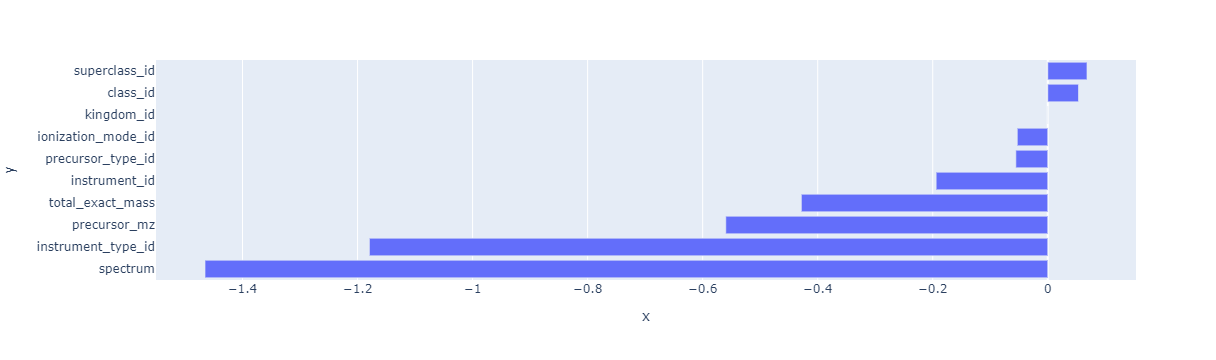

In [21]:
import plotly.express as px
fig = px.bar(x=s.values(), y=s.keys(), orientation='h')
fig.show()

## Save results

In [17]:
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.loc[df['full_model_name'] == model_name, 'feature_importance'] = str(s)
    df.to_csv(csv_path)